利用Torchvision现成的功能进行测试
From Post: https://docs.pytorch.org/tutorials/intermediate/torchvision_tutorial.html

数据集: PennFudan
```bash
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip 
```

In [1]:
# 自动重新加载外部module，使得修改代码之后无需重新import
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

from hdd.device.utils import get_device

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from pathlib import Path

# 设置训练数据的路径
DATA_ROOT = Path("~/workspace/hands-dirty-on-dl/dataset").expanduser()
# 设置预训练模型参数路径
TORCH_HUB_PATH = Path("~/workspace/hands-dirty-on-dl/pretrained_models").expanduser()
torch.hub.set_dir(TORCH_HUB_PATH)
# 挑选最合适的训练设备
DEVICE = get_device(["cuda", "cpu"])
print("Use device: ", DEVICE)

Use device:  cuda


# PennFudanDataset

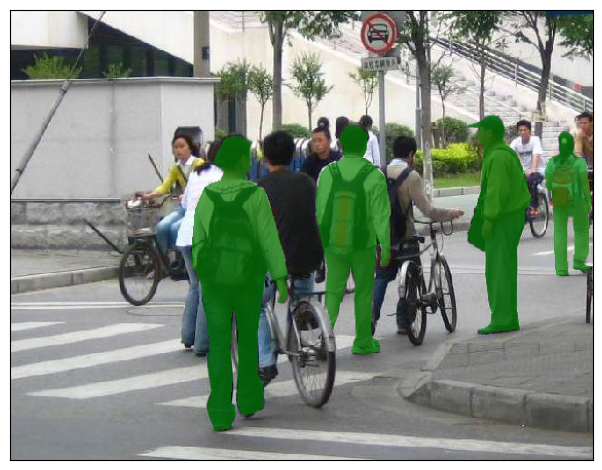

In [2]:
import matplotlib.pyplot as plt
from torchvision.io import read_image
from hdd.visualization.vis_utils import det_seg_plot

image = read_image(DATA_ROOT / "PennFudanPed/PNGImages/FudanPed00046.png")
mask = read_image(DATA_ROOT / "PennFudanPed/PedMasks/FudanPed00046_mask.png")

det_seg_plot([(image, {"masks": mask})])

In [3]:
import os
from rich import box
import torch
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


class PennFudanDataset(torch.utils.data.Dataset):
    """It preloads images into memory, so it is not suitable for large datasets."""

    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        img_paths = list(sorted((self.root / "PNGImages").glob("*.png")))
        mask_paths = list(sorted((self.root / "PedMasks").glob("*.png")))

        assert len(img_paths) == len(
            mask_paths
        ), "Number of images and masks must be the same."

        # Preload images and masks into memory for faster training
        self.imgs = []
        self.masks = []
        for img_path, mask_path in zip(img_paths, mask_paths):
            self.imgs.append(read_image(img_path))
            self.masks.append(read_image(mask_path))

    def __getitem__(self, idx):
        img = self.imgs[idx].clone()
        mask = self.masks[idx].clone()

        obj_ids = torch.unique(mask)
        obj_ids = obj_ids[obj_ids != 0]  # Exclude background
        num_objs = len(obj_ids)

        # Each object has it own mask
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)
        boxes = masks_to_boxes(masks)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)
        target = {
            "boxes": tv_tensors.BoundingBoxes(
                boxes, format="XYXY", canvas_size=F.get_size(img)
            ),
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd,
        }

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self) -> int:
        return len(self.imgs)


dataset = PennFudanDataset(DATA_ROOT / "PennFudanPed")

#### Play with the PennFudanDataset

<Figure size 1200x1200 with 0 Axes>

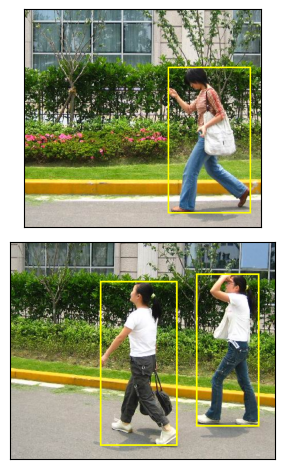

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))

images_to_plot = []
for i in range(10, 12):
    img, target = dataset[i]
    images_to_plot.append([(img, target)])
det_seg_plot(images_to_plot)


In [5]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load a model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

    # replace the classifier with a new one, that has
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [6]:
from torchvision.transforms import v2 as T


def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [7]:
from hdd.scripts.detection.engine import evaluate
import hdd.scripts.detection.utils as utils
import math
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [
            {
                k: v.to(device) if isinstance(v, torch.Tensor) else v
                for k, v in t.items()
            }
            for t in targets
        ]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.detach().to("cpu").item()
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            return

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()


# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = PennFudanDataset(DATA_ROOT / "PennFudanPed", get_transform(train=True))
dataset_test = PennFudanDataset(DATA_ROOT / "PennFudanPed", get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, collate_fn=utils.collate_fn
)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model = model.to(DEVICE)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [8]:
# let's train it just for 2 epochs
num_epochs = 50

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, DEVICE, epoch)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=DEVICE)

print("That's it!")

creating index...
index created!
Test:  [ 0/50]  eta: 0:00:02  model_time: 0.0383 (0.0383)  evaluator_time: 0.0007 (0.0007)  time: 0.0410  data: 0.0018  max mem: 2552
Test:  [49/50]  eta: 0:00:00  model_time: 0.0176 (0.0245)  evaluator_time: 0.0004 (0.0005)  time: 0.0232  data: 0.0019  max mem: 2552
Test: Total time: 0:00:01 (0.0272 s / it)
Averaged stats: model_time: 0.0176 (0.0245)  evaluator_time: 0.0004 (0.0005)
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.763
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.991
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.920
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.525
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.524
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.780
 Average Recall     (AR) @[ IoU=

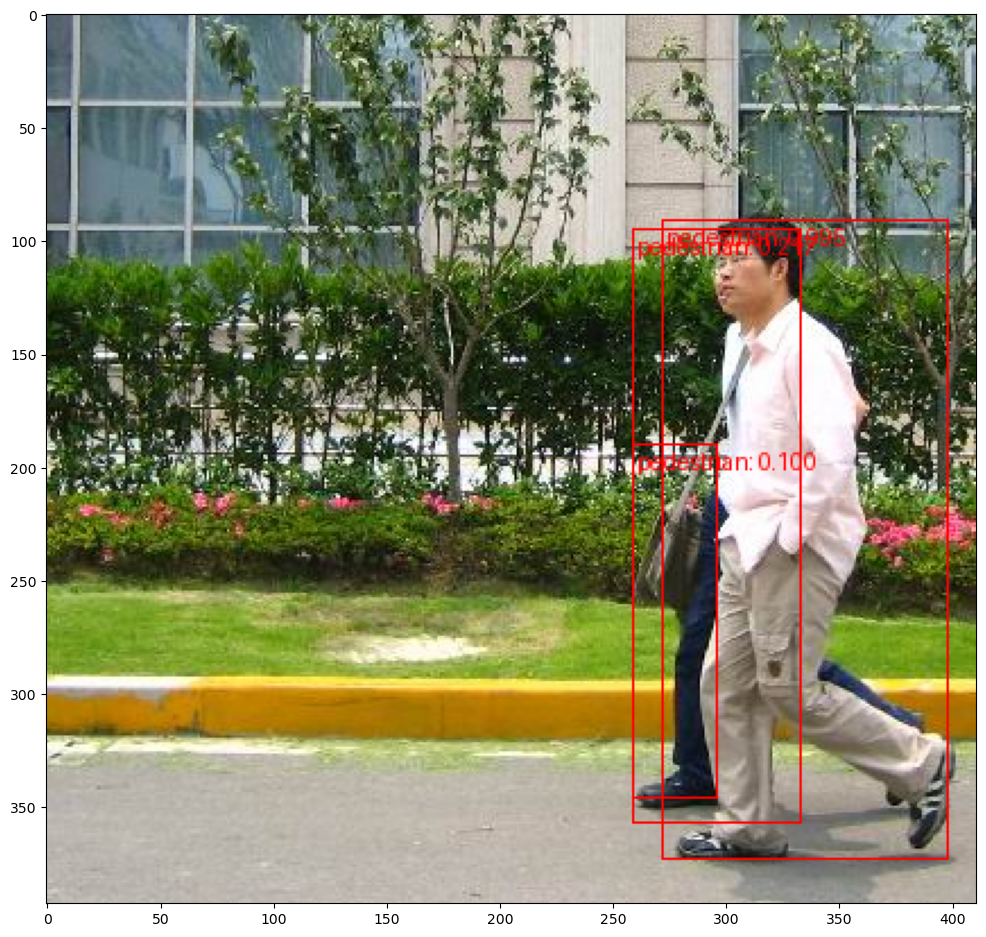

In [15]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks


image = read_image(DATA_ROOT / "PennFudanPed/PNGImages/FudanPed00010.png")
eval_transform = get_transform(train=False)
model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(DEVICE)
    predictions = model(
        [
            x,
        ]
    )
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [
    f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])
]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))